# Space Invaders

# Weights & Biases x Qualcomm - SpaceInvaders Challenge

We’re excited to announce the W&B [SpaceInvaders](https://gym.openai.com/envs/SpaceInvaders-v0/) Challenge, a reinforcement learning competition. Your goal is to train reinforcement learning agents in OpenAI's gym environment. The contestants with the top 3 scores will receive prizes and be invited to present their solutions to the community. The challenge is open to Qualcomm employees only.

This notebook contains code for loading the gym environment, preprocessing data, and calculating & logging the cumulative average reward metrics.

![](https://thumbs.gfycat.com/CookedFriendlyAntarcticfurseal-size_restricted.gif)

## Running this notebook
1. Click "Open in playground" to create a copy of this notebook for yourself.
2. Save a copy in Google Drive for yourself.
3. To enable a GPU, please click Edit > Notebook Settings. Change the "hardware accelerator" to GPU.
4. Step through each section, pressing play on the code blocks to run the cells.
5. Add your own model code.

## Submissions
You may submit your entries [here](https://app.wandb.ai/wandb/spaceinvaders-challenge/benchmark/submit). You'll need a Weights & Biases account to make submissions.

Each run must include the following files:

- Model file generated by [wandb.save()](https://docs.wandb.com/library/python/save)
- Model training script (.py file or notebook)
- Any other files necessary to recreate the model

**Please ensure that you log your model file and all files necessary to recreate the model in your run using [wandb.save()](https://docs.wandb.com/library/python/save). Without this, we will be unable to evaluate your model.**

Also please ensure that your code is not in a public repo, but is visible to us by adding 'lavanyashukla' as a collaborator to your repo. We will use the model saved in the submitted run to recreate the model and evaluate it across the 5 random seeds.

## Evaluation
Your objective is to maximize the best 100-episode average reward. This means your model will play the game for 100 episodes, and we will calculate a running average of the cumulative reward gained as each of the episodes is played. After 100 episodes, this cumulative running average will be your final score for the run.

We encourage you to submit as many runs as you like. To verify results, we will pick the top 5-10 submissions as ranked by the evaluation metric (best 100-episode average reward), and run these agents through the SpaceInvaders environment. We will evaluate how the agents do across 5 randomly generated seeds. This means, your agent will be run for 100 episodes with 5 different seeds and generate a best 100-episode average reward for each seed. We will take the average of these scores to get the final best 100-episode average reward.

Entries will be ranked from highest to lowest by the best 100-episode average reward received across the 5 seeds.

For more details, please visit the [competition website](https://app.wandb.ai/wandb/spaceinvaders-challenge/benchmark/).

In [12]:
!pip install gym pyvirtualdisplay -qq
!apt-get install -y xvfb python-opengl ffmpeg -qq
!pip install xdpyinfo -qq

!apt-get update -qq
!apt-get install cmake -qq
!pip install --upgrade setuptools -qq
!pip install ez_setup -qq

ERROR: Could not find a version that satisfies the requirement xdpyinfo (from versions: none)
ERROR: No matching distribution found for xdpyinfo


In [0]:
!pip install --upgrade wandb -qq

In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)

import numpy as np
import random
import math
import glob
import io
import os
import cv2
import base64
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque
from datetime import datetime
import keras

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

# import wandb
import wandb

## Preprocessing - crop images, convert them to 1D black and white image tensors

- Image dimensions - (210, 160, 3)
- Output dimensions - (88, 80, 1)


In [0]:
color = np.array([210, 164, 74]).mean()

def preprocess_frame(obs):
    # Crop and resize
    img = obs[25:201:2, ::2]

    # Convert to greyscale
    img = img.mean(axis=2)

    # Improve contrast
    img[img==color] = 0

    # Normalzie image
    img = (img - 128) / 128 - 1

    # Reshape to 80*80*1
    img = img.reshape(88,80)

    return img 

## Initialize gym environment and explore game screens


In [16]:
env = gym.make("SpaceInvaders-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print("Actions available(%d): %r"%(env.action_space.n, env.env.get_action_meanings()))

Actions available(6): ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


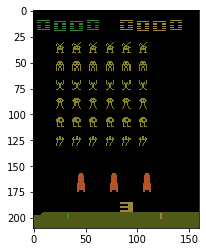

In [17]:
observation = env.reset()
# Game Screen
for i in range(11):
  if i > 9:
    plt.imshow(observation)
    plt.show()
  observation, _, _, _ = env.step(1)

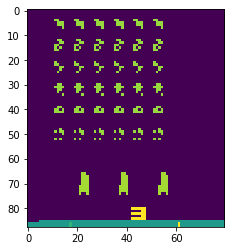

In [18]:
# Preprocessed Game Screen
obs_preprocessed = preprocess_frame(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()

# Evaluation

In [0]:
# **** Caution: Do not modify this cell ****
# initialize total reward across episodes
cumulative_reward = 0
episode = 0

def evaluate(episodic_reward):
  '''
  Takes in the reward for an episode, calculates the cumulative_avg_reward
    and logs it in wandb. If episode > 100, stops logging scores to wandb.
    Called after playing each episode. See example below.

  Arguments:
    episodic_reward - reward received after playing current episode
  '''
  global episode
  global cumulative_reward
  episode += 1
  print("Episode: %d"%(episode))

  # your models will be evaluated on 100-episode average reward
  # therefore, we stop logging after 100 episodes
  if (episode > 100):
    print("Scores from episodes > 100 won't be logged in wandb.")
    return

  # log total reward received in this episode to wandb
  wandb.log({'episodic_reward': episodic_reward})

  # add reward from this episode to cumulative_reward
  cumulative_reward += episodic_reward

  # calculate the cumulative_avg_reward
  # this is the metric your models will be evaluated on
  cumulative_avg_reward = cumulative_reward/episode

  # log cumulative_avg_reward over all episodes played so far
  wandb.log({'cumulative_avg_reward': cumulative_avg_reward})

### Play a random game, log reward and gameplay video in wandb

In this section we'll show you how to save a model in Weights & Biases. This is necessary in order for us to evaluate your model.

Let's train a very basic model to start.

In [0]:
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.learning_rate = wandb.config.learning_rate
        self.epsilon = 1.0
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.05
        self.gamma = 0.95
        self.model = self._build_model()
    
    def _build_model(self):
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(8, activation='relu', input_dim=self.state_size))
        model.add(keras.layers.Dense(16, activation='relu'))
        model.add(keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Nadam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self, state):
        return random.randrange(self.action_size)
    
    def save(self, name):
        self.model.save(name)

    def load(self, name):
        self.model.load_model(name)

Here we adapt the code from the earlier section where we took random actions. We replace these random actions with the outputs from a basic model.

In [21]:
# initialize environment
env = gym.make('SpaceInvaders-v0')

# initialize a new wandb run
wandb.init(project="qualcomm")

# define hyperparameters
wandb.config.episodes = 100
wandb.config.batch_size = 32
wandb.config.learning_rate = 0.003
input_shape = (None, 88, 80, 1)
agent = DQN(state_size, action_size)   

# record gameplay video
display = Display(visible=0, size=(1400, 900))
display.start()

# run for 100 episodes
for i in range(wandb.config.episodes):
  # Set reward received in this episode = 0 at the start of the episode
  episodic_reward = 0

  # record a video of the game using wrapper
  env = gym.wrappers.Monitor(env, './video', force=True)
  
  # play a random game
  state = env.reset()
  state = preprocess_frame(state)

  done = False
  while not done:
    # get prediction for next action from model
    # ****TODO: replace this with your model's prediction****
    action = agent.act(state)

    # perform the action and fetch next state, reward
    next_state, reward, done, _ = env.step(action)
    next_state = preprocess_frame(next_state)
    agent.remember(state, action, reward, next_state, done)
    state = next_state

    episodic_reward += reward
  
  # call evaluation function - takes in reward received after playing an episode
  # calculates the cumulative_avg_reward over 100 episodes & logs it in wandb
  evaluate(episodic_reward)

  if len(agent.memory) > wandb.config.batch_size:
    agent.train(wandb.config.batch_size)

  # your models will be evaluated on 100-episode average reward
  # therefore, we stop logging after 100 episodes
  if (i == 99):
    # ---- Save the model in Weights & Biases ----
    agent.save(os.path.join(wandb.run.dir, "model.h5"))
    break

  record_video = False
  env.close() 

  # render gameplay video
  if (i %50 == 0):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
      print(len(mp4list))
      mp4 = mp4list[-1]
      video = io.open(mp4, 'r+b').read()
      encoded = base64.b64encode(video)

      # log gameplay video in wandb
      wandb.log({"gameplays": wandb.Video(mp4, fps=4, format="gif")})

      # display gameplay video
      ipythondisplay.display(HTML(data='''<video alt="" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
              </video>'''.format(encoded.decode('ascii'))))

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


Episode: 1
1


Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
1


Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
Episode: 58
Episode: 59
Episode: 60
Episode: 61
Episode: 62
Episode: 63
Episode: 64
Episode: 65
Episode: 66
Episode: 67
Episode: 68
Episode: 69
Episode: 70
Episode: 71
Episode: 72
Episode: 73
Episode: 74
Episode: 75
Episode: 76
Episode: 77
Episode: 78
Episode: 79
Episode: 80
Episode: 81
Episode: 82
Episode: 83
Episode: 84
Episode: 85
Episode: 86
Episode: 87
Episode: 88
Episode: 89
Episode: 90
Episode: 91
Episode: 92
Episode: 93
Episode: 94
Episode: 95
Episode: 96
Episode: 97
Episode: 98
Episode: 99
Episode: 100


In [0]:
# Load the model
agent.load(os.path.join(wandb.run.dir, "model.h5")) 